In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import random_light as rl
import readpng as rpng
import tikhonov as tik
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [3]:
img=rpng.get_bwimg("che.png")
Mx,My=np.shape(img)
Mmodel=Mx*My
Ndata=1024
d,W,imgext=rl.create_data_and_designmatrix(img,N=Ndata,p=0.7,width=10)

/home/kawahara/.pyenv/versions/anaconda3-2019.07/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kawahara/.pyenv/versions/anaconda3-2019.07/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Here is the input image (left) and the observed image (right)

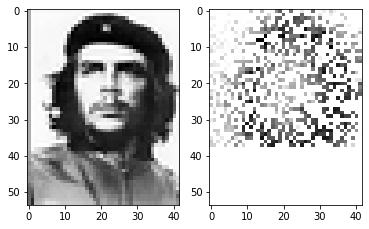

In [51]:
fig=plt.figure()
ax=fig.add_subplot(121)
plt.imshow(img,cmap="gray")
ax=fig.add_subplot(122)
plt.imshow(imgext,cmap="gray")

Singular Value Decomposition of the design matrix

In [5]:
U,S,VT=np.linalg.svd(W)

Text(0, 0.5, 'Singular value')

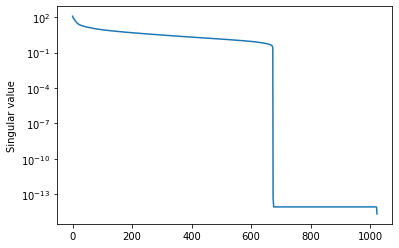

In [6]:
plt.plot(S)
plt.yscale("log")
plt.ylabel("Singular value")

In [7]:
def each_img(i,d):
    return (1.0/S[i])*np.inner(U[:,i],d)*VT[i,:]

In [8]:
cube=[]
for i in range(0,np.min([Ndata,Mmodel])):
    cube.append(each_img(i,d))
cube=np.array(cube)
cumcube=(np.cumsum(cube,axis=0))

In [52]:
from ipywidgets import Play, IntSlider, jslink, HBox, interactive_output
import time
Ndata,Mmodel=np.shape(W)
def f(i):
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(131)
    plt.plot(S)
    plt.plot(i,S[i],"o",color="red")
    plt.yscale("log")
    plt.ylabel("Singular value")
    ax=fig.add_subplot(132)
    plt.imshow(cube[i].reshape(Mx,My),cmap="gray")
    plt.title("Each Image")
    ax=fig.add_subplot(133)
    plt.imshow(cumcube[i].reshape(Mx,My),cmap="gray")
    plt.title("Cumulative")
    plt.show()

play = Play(value=0, min=0, max=np.min([Ndata,Mmodel])-1, step=1, interval=150, description="Press play",)
slider = IntSlider(min=0, max=np.min([Ndata,Mmodel])-1)
jslink((play, 'value'), (slider, 'value'))
ui = HBox([play, slider])
out = interactive_output(f, {'i': slider})
display(ui, out)



Output()

## Moore-Penrose Matrix

In [10]:
def MP(d,lim=1.e-13):
    Ndata,Mmodel=np.shape(W)
    plim = np.sum(S>lim)
    Sm=np.zeros(Mmodel)
    for i in range(0,plim):
        Sm=Sm+each_img(i,d)
    return Sm

Text(0.5, 1.0, 'Moore-Penrose Inverse Matrix')

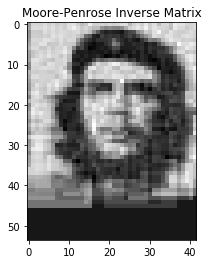

In [53]:
Sm=MP(d)
plt.imshow(Sm.reshape(Mx,My),cmap="gray")
plt.title("Moore-Penrose Inverse Matrix")

In [12]:
## noise injection

In [13]:
sigma=0.03
dn = d + np.random.normal(0.0,np.mean(d)*sigma,np.shape(d))

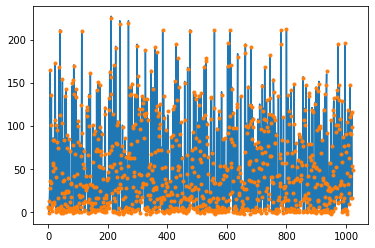

In [14]:
plt.plot(d)
plt.plot(dn,".")

Text(0.5, 1.0, 'Moore-Penrose Inverse Matrix')

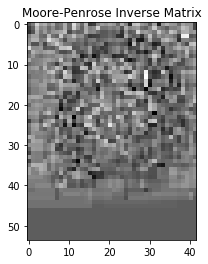

In [54]:
Sm=MP(dn)
plt.imshow(Sm.reshape(Mx,My),cmap="gray")
plt.title("Moore-Penrose Inverse Matrix")

Text(0.5, 1.0, 'Moore-Penrose Inverse Matrix')

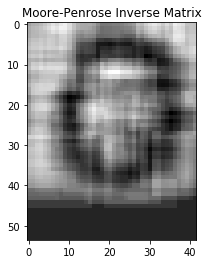

In [55]:
Sm=MP(dn,lim=1.e1)
plt.imshow(Sm.reshape(Mx,My),cmap="gray")
plt.title("Moore-Penrose Inverse Matrix")

## Tikhonov Regularization

In [17]:
def Tikh(d,lambdatik):
    p=min(Ndata,Mmodel)
    Sm=np.zeros(Mmodel)
    for i in range(0,p):
        phij=(S[i]/(S[i]**2+lambdatik**2))
        Sm=Sm+phij*np.inner(U[:,i],d)*VT[i,:]
    return Sm

Text(0.5, 1.0, 'Tikhonov')

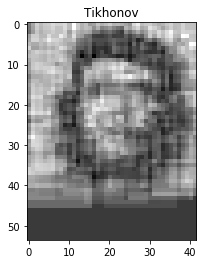

In [56]:
Sm=Tikh(dn,lambdatik=3.0)
plt.imshow(Sm.reshape(Mx,My),cmap="gray")
plt.title("Tikhonov")

## Gaussian Process

In [19]:
def Mean_BayesLIP(W,KS,lc,Pid):
    #mean of the posterior given theta and g
    #Pid: data precision matrix (inverse of the data covariance)
    Kw=(W@KS@W.T)
    Nn=np.shape(Kw)[0]
    IKw=np.eye(Nn)+Pid@Kw
    Xlc=scipy.linalg.solve(IKw,Pid@lc,assume_a="pos")
    return KS@W.T@Xlc

In [20]:
gx=((np.array([range(0,Mx)]).T)*np.ones(My))
gy=((np.array([range(0,My)]).T)*np.ones(Mx)).T
gx=gx.flatten()
gy=gy.flatten()
dx = gx - np.array([gx]).T
dy = gy - np.array([gy]).T
sep = np.sqrt(dx*dx + dy*dy)

In [21]:
def RBF(sep,gamma):
    K=np.exp(-(sep)**2/2/(gamma**2))
    return K

In [22]:
def Matern32(sep,gamma):
    fac=np.sqrt(3.0)*np.abs(sep)/gamma
    K=(1.0+fac)*np.exp(-fac)
    return K

In [63]:
gamma=1
alpha=0.1
#KS=alpha*RBF(sep,gamma)
KS=alpha*Matern32(sep,gamma)
Pid=(sigma*np.mean(d))**-2*np.eye(Ndata) #Data precision matrix
mu=Mean_BayesLIP(W,KS,dn,Pid)

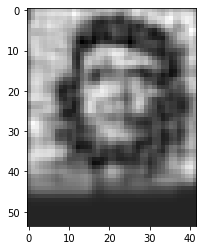

In [64]:
plt.imshow(mu.reshape(Mx,My),cmap="gray")

## MCMC

In [25]:
import emcee

In [26]:
def log_prior(theta):
    p_gamma,p_alpha=theta
    if 0.1 < p_gamma < 50 and 1.e-6 < p_alpha < 1.e6:
        return np.log(1.0/p_alpha/p_gamma)
    return -np.inf

def log_likelihood(theta, d, covd):
    p_gamma,p_alpha=theta
    KS=p_alpha*Matern32(sep,p_gamma)
    Cov = covd + W@KS@W.T
    sign,logdet=np.linalg.slogdet(Cov)
    Pi_d=scipy.linalg.solve(Cov,d,assume_a="pos")
    prop = -0.5*logdet-0.5*d@Pi_d #-0.5*np.shape(cov)[0]*np.log(2.0*np.pi)
    return prop

def log_probability(theta, d, covd):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, d, covd)

In [41]:
gam0=3.0
alpha0=0.001
pos = np.array([gam0,alpha0])+ 1e-4 * np.random.randn(16, 2)
nwalkers, ndim = pos.shape
Ns=500
#Assumming we know the data covariance
covd=(sigma*np.mean(d))**2*np.eye(Ndata)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(dn, covd))
sampler.run_mcmc(pos, Ns, progress=True);

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

100%|██████████| 500/500 [1:17:26<00:00,  7.19s/it]


In [42]:
inputgeo=[gam0,alpha0]
np.savez("che_sample",flat_samples,W,dn,inputgeo)


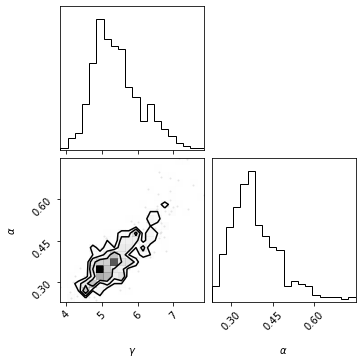

In [66]:

import corner
fig = corner.corner(flat_samples[50:,:], labels=["$\\gamma$","$\\alpha$"], truths=[gam0,alpha0])
plt.savefig("corner.png")
plt.savefig("corner.pdf")
plt.show()


In [67]:
gamma=5
alpha=0.35
#KS=alpha*RBF(sep,gamma)
KS=alpha*Matern32(sep,gamma)
Pid=(sigma*np.mean(d))**-2*np.eye(Ndata) #Data precision matrix
mu=Mean_BayesLIP(W,KS,dn,Pid)

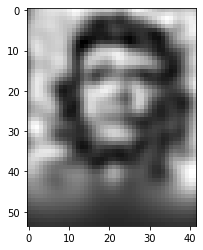

In [68]:
plt.imshow(mu.reshape(Mx,My),cmap="gray")